# CPSC 330 - Applied Machine Learning 

## Homework 5: Evaluation metrics
### Associated lectures: [Lectures 9, 10](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Feb 27, 2023 at 11:59pm**

## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Instructions 
<hr>
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has cancer or not. It is important to catch this disease early to reduce mortality rate; late diagnosis will result in metastasis to other organs, which adversely impacts patient's prognosis. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|         | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 48 | 32 |
| **Actual no disease**       | 20 | 100 |


- Model B

|        | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 43 | 22 |
| **Actual no disease**       | 35 | 100 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

In spotting problems, the positive class is the thing that we're interested in spotting. In the context of this problem, we're interested in spotting whether or not a patient has cancer. Hence, the positive class is "disease" and the negative class is "no disease".

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [2]:
results_dict = {"A": {}, "B": {}}

In [3]:
results_dict["A"]["accuracy"] = (48+100)/(48+100+20+32)
results_dict["B"]["accuracy"] = (43+100)/(43+22+35+100)

print(results_dict["A"]["accuracy"])
print(results_dict["B"]["accuracy"])

0.74
0.715


<br><br>

#### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

I would pick model A because the accuracy is higher (0.74 > 0.715).

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [4]:
results_dict["A"]["precision"] = 48/(48+20)
results_dict["B"]["precision"] = 43/(43+35)
results_dict["A"]["recall"] = 48/(48+32)
results_dict["B"]["recall"] = 43/(43+22)
results_dict["A"]["f1"] = 2*((results_dict["A"]["precision"]*results_dict["A"]["recall"])/(results_dict["A"]["precision"]+results_dict["A"]["recall"]))
results_dict["B"]["f1"] = 2*((results_dict["B"]["precision"]*results_dict["B"]["recall"])/(results_dict["B"]["precision"]+results_dict["B"]["recall"]))

Show the dataframe with all results. 

In [5]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.740000,0.715000
precision,0.705882,0.551282
recall,0.600000,0.661538
f1,0.648649,0.601399


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Given the type of problem (early cancer diagnosis), which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

1. With early cancer diagnosis, it is more harmful to have a false negative since that leads to a missed diagnosis, which can be life-threatening. Hence, recall is the most important metric since it is a measure of how many positive examples our model can capture. A low recall score would mean that our model is predicting a lot of false negatives.
2. I would model B since it has a higher recall score.

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 2 to 3 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [6]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [7]:
churn = train_df["churn"].value_counts()[True]
no_churn = train_df["churn"].value_counts()[False]
print(f"Churn: {churn/(churn+no_churn)}")
print(f"No churn: {no_churn/(churn+no_churn)}")

Churn: 0.1495927989712816
No churn: 0.8504072010287184


Only about 15% of the training examples are in the "Churn" class, which suggests a class imbalance. It is important that we deal with this imbalance because as a business, we are interested in understanding why customers churn so we need to be able to have a model that can correctly predict which customers will churn. 

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

<br><br>

### 2.3 Column transformer 
rubric={points:14}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

For each group of features (e.g. numeric, categorical or else) explain why you are applying the particular transformation. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

Finally, fit `ColumnTransformer` on your training set; and use the `ColumnTransformer` to transform your train data.

In [8]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

**Start with some EDA (scroll down to skip to transformations)**:

In [9]:
X_train

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,204.7,77,17.40,256.6,101,11.55,5.7,4,1.54,1
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,142.3,76,12.10,91.2,86,4.10,10.9,5,2.94,2
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,89.7,103,7.62,220.0,91,9.90,15.6,4,4.21,2
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,163.1,105,13.86,282.5,100,12.71,10.0,3,2.70,1
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,261.5,95,22.23,241.6,104,10.87,11.4,9,3.08,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,246.5,112,20.95,285.3,104,12.84,12.5,8,3.38,2
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,170.0,92,14.45,127.9,68,5.76,9.4,4,2.54,3
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,139.8,121,11.88,171.6,96,7.72,11.6,7,3.13,2
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,246.1,147,20.92,242.0,106,10.89,10.4,5,2.81,1


In [10]:
X_train.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000,2333.000000
mean,100.434634,436.324046,8.028290,179.655679,100.567081,30.542015,201.175782,99.885555,17.100210,201.211745,99.988856,9.054591,10.269567,4.503215,2.773365,1.551650
std,39.642470,41.854200,13.665229,54.546284,20.202414,9.272847,50.449386,19.788878,4.288194,50.888058,19.406455,2.290012,2.777601,2.507555,0.749929,1.328702
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.400000,87.000000,24.380000,167.300000,87.000000,14.220000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.200000,101.000000,30.460000,202.400000,100.000000,17.200000,201.600000,100.000000,9.070000,10.400000,4.000000,2.810000,1.000000
75%,127.000000,415.000000,19.000000,216.300000,114.000000,36.770000,236.000000,113.000000,20.060000,236.600000,113.000000,10.650000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,354.200000,168.000000,30.110000,377.500000,164.000000,16.990000,20.000000,20.000000,5.400000,9.000000


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 1402 to 1346
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account length          2333 non-null   int64  
 2   area code               2333 non-null   int64  
 3   phone number            2333 non-null   object 
 4   international plan      2333 non-null   object 
 5   voice mail plan         2333 non-null   object 
 6   number vmail messages   2333 non-null   int64  
 7   total day minutes       2333 non-null   float64
 8   total day calls         2333 non-null   int64  
 9   total day charge        2333 non-null   float64
 10  total eve minutes       2333 non-null   float64
 11  total eve calls         2333 non-null   int64  
 12  total eve charge        2333 non-null   float64
 13  total night minutes     2333 non-null   float64
 14  total night calls       2333 non-null

In [12]:
X_train["state"].unique()

array(['NE', 'WI', 'NJ', 'NV', 'HI', 'NM', 'MO', 'MI', 'SD', 'WY', 'GA',
       'WV', 'KS', 'DC', 'CT', 'TN', 'AK', 'WA', 'MS', 'CA', 'ND', 'MD',
       'AZ', 'RI', 'SC', 'AL', 'MA', 'ME', 'AR', 'VA', 'FL', 'NY', 'DE',
       'NH', 'MN', 'KY', 'NC', 'OK', 'OR', 'ID', 'IN', 'LA', 'UT', 'PA',
       'TX', 'OH', 'MT', 'IA', 'VT', 'IL', 'CO'], dtype=object)

In [13]:
X_train["area code"].unique()

array([415, 510, 408])

In [14]:
print(len(X_train["phone number"].unique()))

2333


In [15]:
print(len(X_train["international plan"].unique()))

2


In [16]:
print(len(X_train["voice mail plan"].unique()))

2


**Based on the EDA above, we will perform the following transformations (justifications provided as comments in the code)**:

In [17]:
# Perform OHE on `state` and `area code` because they are both categorical variables without inherent order
categorical_features = ["state", "area code"]

# Perform OHE with arg `drop=if_binary` because `international plan` and `voice mail plan` 
# are both categorical features with binary values "yes" and "no"
binary_features = ["international plan", "voice mail plan"]

# Drop `phone number` because each customer hasa a unique number, so this feature won't 
# have a meaningful effect on the prediction
drop_features = ["phone number"]

# Perform scaling on all the other features because they are numeric
numeric_features = list(
    set(X_train.columns)
    - set(categorical_features)
    - set(binary_features)
    - set(drop_features)
)

# Preprocessor
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    (OneHotEncoder(handle_unknown="ignore", drop='if_binary'), binary_features),
    (StandardScaler(), numeric_features),
    ("drop", drop_features)
)

preprocessor

ColumnTransformer(transformers=[('onehotencoder-1',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['state', 'area code']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['international plan', 'voice mail plan']),
                                ('standardscaler', StandardScaler(),
                                 ['total eve calls', 'number vmail messages',
                                  'total eve minutes', 'total day calls',
                                  'total night calls', 'account length',
                                  'total day minutes', 'total intl minutes',
                                  'total eve charge', 'total intl calls',
                                  'total intl charge', 'total day charge',
                                  'customer service calls',
                                  'total night minutes',
                                  'total night charge']),
                                ('drop', 'drop', ['phone number'])])

<br><br>

<br><br>

### 2.4 area code feature
rubric={points:4}

The original dataset had a feature called `area code`.

1. The area codes are numbers. Does it make sense to encode them as one-hot-endoded (OHE) or not? Please justify your response.
2. What were the possible values of `area code`? 
3. If area code is encoded with OHE, how many new features are created to replace it?

1. It makes sense to use OHE on area codes because they are categorical values that don't hold meaning as a numeric values. Each area code represents a geographic region bucket/category in which many customers may live. 
2. The possible values of `area code` are:

In [18]:
print(X_train["area code"].unique())

[415 510 408]


3. Three new features are created, one for each unique `area code`.

<br><br>

### 2.5 Logistic regression
rubric={points:12} 

**Your tasks:**

1. Report the cross-validation results of a `LogisticRegression` model, with default Hparams, on the following metrics: `"accuracy", "precision", "recall", "f1"`
2. Are you satisfied with the results? Explain why or why not. Discuss in a few sentences. 

1. Reporting on cv results:

In [19]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression())
metrics = cross_validate(lr_pipe, X_train, y_train, return_train_score=True, scoring=["accuracy", "precision", "recall", "f1"])
pd.DataFrame(metrics)[["test_accuracy", "test_precision", "test_recall", "test_f1"]].mean()

test_accuracy     0.855978
test_precision    0.548663
test_recall       0.209317
test_f1           0.302739
dtype: float64

2. No, I'm not satisfied because the only metric that the model is performing well on is `accuracy`, which makes sense because we have a class imbalance. The model has a low precision of roughly 55%, which suggests that the 45% of the churns that the model is producing are false positives. The model also has a low recall of roughly 21%, which means that it is failing to identify 79% of the positive examples (i.e., churning customers). Because the model has low precision and recall, it also has a low f1 score.

<br><br>

### 2.6 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences while comparing the metrics of this model and the previous model.

1. Reporting on cv results:

In [20]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(class_weight='balanced'))
metrics = cross_validate(lr_pipe, X_train, y_train, return_train_score=True, scoring=["accuracy", "precision", "recall", "f1"])
pd.DataFrame(metrics)[["test_accuracy", "test_precision", "test_recall", "test_f1"]].mean()

test_accuracy     0.760807
test_precision    0.351154
test_recall       0.699213
test_f1           0.467027
dtype: float64

2. I do prefer this model because we said at the beginning of this section that it is important our model can identify our churning customers (i.e., postive examples). The recall for this model is roughly 70%, which is much higher than 21% in the previous model, which means we are identifying more positve examples, albeit at the expense of more false positives (as indicated by our lower precision). Overall, our accuracy went down a bit, but our f1 score went up. This is expected because by passing in the argument `class_weight='balanced'`, we are making the weights of the classes equal, which helps mitigate the class imbalance problem.

<br><br>

### 2.7 Hyperparameter optimization
rubric={points:10}

1. Jointly optimize `C` and `class_weight` with `GridSearchCV` and `scoring="f1"`.
  - For `class_weight`, consider 3 values: 
    - `None` (no weight)
    - "weight of class 0 = 1"  and  "weight of class 1 = 3"
    - '`balanced`'
  - For `C`, choose some reasonable values
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

1. Optimize `C` and `class_weight` with `GridSearchCV` and `scoring='f1'`:

In [21]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr_pipe.get_params('logisticregression')

param_grid = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "logisticregression__class_weight": [None, {0:1, 1:3}, 'balanced']
}

grid_search = GridSearchCV(
    lr_pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring='f1'
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder-1',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['state',
                                                                          'area '
                                                                          'code']),
                                                                        ('onehotencoder-2',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['t...
                                                                          'charge',
                                                                          'customer '
                                                                          'service '
                                                                          'calls',
                                                                          'total '
                                                                          'night '
                                                                          'minutes',
                                                                          'total '
                                                                          'night '
                                                                          'charge']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['phone '
                                                                          'number'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                   100],
                         'logisticregression__class_weight': [None,
                                                              {0: 1, 1: 3},
                                                              'balanced']},
             return_train_score=True, scoring='f1')

2. The best parameter values and best CV f1 score are shown below:

In [22]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'logisticregression__C': 0.1, 'logisticregression__class_weight': {0: 1, 1: 3}}
0.4901064071511795



<br><br>

### 2.8 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Plot Confusion matrix
    - Plot Precision-recall curve 
    - Calculate average precision score
    - Plot ROC curve
    - Report AUC score
3. Comment on the AUC score and give an intuitive explanation of what this value of AUC means for this problem.

1. Code for plots and score computations are copied from lecture 9:

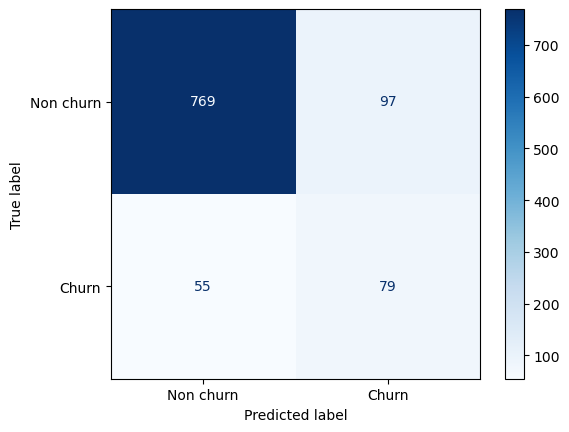

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    grid_search,
    X_test,
    y_test,
    display_labels=["Non churn", "Churn"],
    values_format="d",
    cmap=plt.cm.Blues,
)

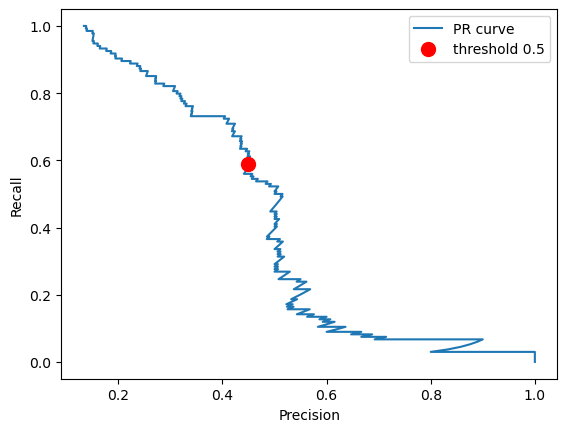

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, grid_search.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, grid_search.predict(X_test)),
    recall_score(y_test, grid_search.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [25]:
from sklearn.metrics import average_precision_score
y_predict = grid_search.predict_proba(X_test)[:, 1]

average_precision = average_precision_score(y_test, y_predict)
print(f'The average precision score is {average_precision}')

The average precision score is 0.4653216145225093


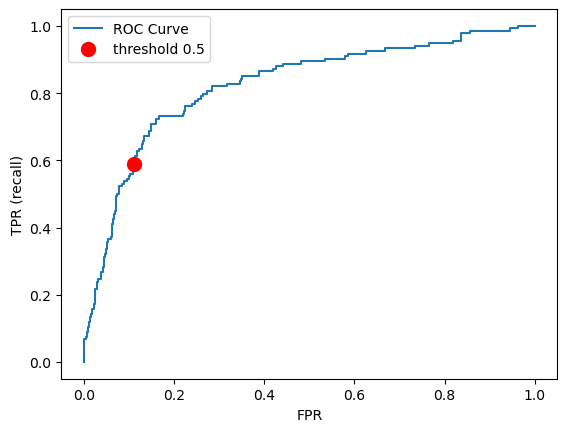

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [27]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
print(f'The AUC score is {roc}')

The AUC score is 0.8239719416772948


2. The AUC score tells us that there's roughly an 82% chance that a randomly chosen positive example has a higher `predict_proba` score than a randomly picked negative example. This means that the model is successfully predicting many of the customers who churn (i.e., high TPR), while mispredicting only a low number of customers as churning when they don't (i.e., low FPR).

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [28]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (75%) and test (25%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` to train and test splits. 

1. Split data into train and test splits:

In [29]:
train_df, test_df = train_test_split(housing_df, test_size=0.25, random_state=123)

3. Separate `X` and `y` to train and test splits:

In [30]:
X_train = train_df.drop(columns=["MedHouseVal"])
X_test = test_df.drop(columns=["MedHouseVal"])
y_train = train_df["MedHouseVal"]
y_test = test_df["MedHouseVal"]

2. EDA on train split:

In [31]:
train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
19995,1.0349,6.0,4.165217,0.982609,734.0,3.191304,36.19,-119.35,0.678
17889,4.7625,13.0,5.265207,1.002433,1087.0,2.644769,37.41,-121.95,1.375
1977,3.5192,9.0,8.747475,1.845118,796.0,2.680135,38.61,-120.44,0.980
6861,2.8672,30.0,4.635616,1.090411,1130.0,3.095890,34.06,-118.13,1.985
11247,4.1276,13.0,4.429936,0.963376,1749.0,2.785032,33.81,-118.00,1.538
...,...,...,...,...,...,...,...,...,...
7763,3.6389,36.0,5.584615,1.115385,490.0,3.769231,33.91,-118.10,1.676
15377,4.5391,14.0,6.016688,1.017972,2436.0,3.127086,33.37,-117.24,1.809
17730,5.6306,5.0,5.958393,1.031564,2435.0,3.493544,37.33,-121.76,2.862
15725,3.8750,44.0,4.739264,1.024540,561.0,1.720859,37.78,-122.44,4.125


In [32]:
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.875935,28.550000,5.421818,1.095860,1437.431137,3.073942,35.626601,-119.568380,2.074085
std,1.900729,12.546577,2.519280,0.492851,1131.575270,10.971330,2.135537,2.001982,1.156051
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.562500,18.000000,4.433750,1.005778,791.000000,2.429227,33.930000,-121.800000,1.203000
50%,3.534300,29.000000,5.228714,1.048412,1173.000000,2.815468,34.250000,-118.490000,1.805000
75%,4.750375,37.000000,6.047297,1.099043,1742.000000,3.278071,37.710000,-118.010000,2.655000
max,15.000100,52.000000,141.909091,34.066667,28566.000000,1243.333333,41.950000,-114.310000,5.000010


It seems like all our data is numeric, so they could benefit from scaling:

In [33]:
numeric_features = list(set(X_train.columns))
preprocessor = make_column_transformer((StandardScaler(), numeric_features))
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['MedInc', 'AveRooms', 'AveBedrms', 'HouseAge',
                                  'AveOccup', 'Longitude', 'Latitude',
                                  'Population'])])

<br><br>

### 3.2 Baseline: Linear Regression 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `sklearn.linear_model.LinearRegression` with default scoring. 
2. What metric is used for scoring by default? 

In [34]:
from sklearn.linear_model import LinearRegression

linreg_pipe = make_pipeline(preprocessor, LinearRegression())
metrics_default = cross_validate(linreg_pipe, X_train, y_train, return_train_score=True)
metrics_r2 = cross_validate(linreg_pipe, X_train, y_train, return_train_score=True, scoring=["r2"])
print('\n' + "Default")
print(pd.DataFrame(metrics_default).mean())
print('\n' + "R2")
print(pd.DataFrame(metrics_r2).mean())


Default
fit_time       0.005106
score_time     0.001177
test_score     0.486547
train_score    0.606753
dtype: float64

R2
fit_time      0.005045
score_time    0.001127
test_r2       0.486547
train_r2      0.606753
dtype: float64


Notice that the scores in the dataframes above are identical. This means that the default scoring metric for `LinearRegression` is $R^2$.

<br><br>

### 3.3 Random Forest Regressor
rubric={points:7}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for two model (`models`) and five evaluation metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [35]:
models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "neg_mean_absolute_percentage_error": "neg_mean_absolute_percentage_error",
}

In [36]:
for key, val in models.items():
    pipeline = make_pipeline(preprocessor, val)
    
    scores = cross_validate(pipeline, 
                            X_train, 
                            y_train, 
                            return_train_score=True, 
                            scoring=score_types_reg)
    
    scores_df = pd.DataFrame(scores).mean()
    print('\n' + key)
    print(scores_df)


Ridge
fit_time                                    0.002579
score_time                                  0.001254
test_neg_mean_squared_error                -0.678763
train_neg_mean_squared_error               -0.525484
test_neg_root_mean_squared_error           -0.808948
train_neg_root_mean_squared_error          -0.724900
test_neg_mean_absolute_error               -0.536109
train_neg_mean_absolute_error              -0.531897
test_r2                                     0.486522
train_r2                                    0.606753
test_neg_mean_absolute_percentage_error    -0.319265
train_neg_mean_absolute_percentage_error   -0.316948
dtype: float64

Random Forest
fit_time                                    4.616006
score_time                                  0.055612
test_neg_mean_squared_error                -0.267731
train_neg_mean_squared_error               -0.037757
test_neg_root_mean_squared_error           -0.517318
train_neg_root_mean_squared_error          -0.194303
test_neg_

Compared to the baseline (Linear Regression), Ridge Regression has the same r2 score (~ 0.60) whereas Random Forest has a much higher r2 score (~0.80). Random Forest also has lower neg MSE, neg RMSE, neg MAE, and neg MAPE than Ridge Regression, which suggests that Random Forest is performing better.

<br><br>

### 3.4 Hyperparameter optimization 
rubric={points:1}

1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose `neg_mean_absolute_percentage_error` as the HParam optimization metric.

2. What was the best `alpha` hyper-parameter found?

In [37]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

# Make pipeline
pipe_ridge = make_pipeline(preprocessor, Ridge())

# Randomized Search
random_search = RandomizedSearchCV(
    pipe_ridge, 
    param_distributions=param_dist, 
    n_jobs=-1, 
    n_iter=20, 
    cv=5,
    random_state=123,
    scoring="neg_mean_absolute_percentage_error"
)

random_search.fit(X_train, y_train)
print(f"Best alpha: {random_search.best_params_['ridge__alpha']}")

Best alpha: 26.789982776216593


<br><br>

### 3.5 Test results
rubric={points:4}

**Your tasks:**

Test the best model (from 3.4) on the test set based on the `neg_mean_absolute_percentage_error` score.

In [38]:
random_search.score(X_test, y_test)

-0.316223945902998

<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Explore coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: 
   - features 
   - coefficients
2. Increasing which feature values would result in higher housing price? 

In [39]:
data = {
    "features": X_train.columns,
    "coefficients": random_search.best_estimator_.named_steps['ridge'].coef_
}

ridge_df = pd.DataFrame(data)
ridge_df.sort_values(by="coefficients", ascending=False)

,features,coefficients
0,MedInc,0.834197
2,AveRooms,0.306563
3,AveBedrms,0.120021
7,Longitude,-0.002402
4,Population,-0.042213
1,HouseAge,-0.270699
5,AveOccup,-0.842722
6,Latitude,-0.873340


Increasing `MedInc`, `AveRooms`, `AveBedrms` would result in a higher housing price.  

<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 